In [1]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
from src.TopoExplanation import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

In [3]:
# dataset link: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

--2021-05-28 03:45:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:443... connected.
Unable to establish SSL connection.


In [3]:
!unzip -f bank-additional.zip -d ../dataset/

unzip:  cannot find or open bank-additional.zip, bank-additional.zip.zip or bank-additional.zip.ZIP.


## Import Bank Dataset

In [2]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
df = pd.read_csv("../dataset/bank-additional/bank-additional.csv", sep=";")
"""
# from the original data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
# duration: last contact duration, in seconds (numeric). 
# Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no')...
this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
"""
X = df.drop(columns=["y", "duration"])#
y = df["y"]

# Basic encoding
cat_cols = [x for x,dtype in zip(df.columns, df.dtypes) if dtype == "object" and x != "y"]
enc_x = OrdinalEncoder()
X.loc[:, cat_cols] = enc_x.fit_transform(X.loc[:, cat_cols])

enc_y = LabelEncoder()
y.loc[:] = enc_y.fit_transform(y)
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,1.0,1.0,2.0,0.0,2.0,0.0,0.0,6.0,0.0,2,999,0,1.0,-1.8,92.893,-46.2,1.313,5099.1
1,39,7.0,2.0,3.0,0.0,0.0,0.0,1.0,6.0,0.0,4,999,0,1.0,1.1,93.994,-36.4,4.855,5191.0
2,25,7.0,1.0,3.0,0.0,2.0,0.0,1.0,4.0,4.0,1,999,0,1.0,1.4,94.465,-41.8,4.962,5228.1
3,38,7.0,1.0,2.0,0.0,1.0,1.0,1.0,4.0,0.0,3,999,0,1.0,1.4,94.465,-41.8,4.959,5228.1
4,47,0.0,1.0,6.0,0.0,2.0,0.0,0.0,7.0,1.0,1,999,0,1.0,-0.1,93.200,-42.0,4.191,5195.8


## Train a neural network model with two hidden layers

In [3]:
batch_size = 16
num_epochs = 100
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [4]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# scaler = StandardScaler().fit(X_train)
# X_train.loc[:] = scaler.transform(X_train)
# X_test.loc[:]  = scaler.transform(X_test)

X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [6]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.29017 | Acc: 89.919 | F1: 15.46243
Epoch 040: | Loss: 0.28441 | Acc: 90.023 | F1: 19.98211
Epoch 060: | Loss: 0.27813 | Acc: 90.023 | F1: 19.32700
Epoch 080: | Loss: 0.27580 | Acc: 90.133 | F1: 20.96477
Epoch 100: | Loss: 0.26901 | Acc: 90.364 | F1: 23.58932
Set to eval


In [7]:
X_test.shape

(1360, 19)

In [8]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()
X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (1167, 19)
Y_test of correct predictions shape: (1167,)
Label in Y_test of correct predictions ratio: 
 [[   0 1087]
 [   1   80]]


## Use the sigmoid function as the prediction probability function for Mapper

[<matplotlib.lines.Line2D at 0x7fde80610090>]

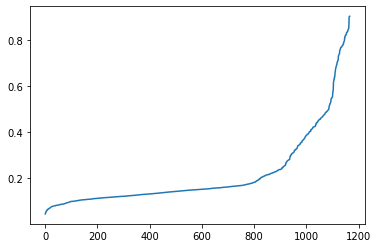

In [9]:
predictions = torch.sigmoid(model(X_test_c_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [10]:
np.random.seed(rs)
torch.manual_seed(rs)

print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [11]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_c_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]
    for exp in explanations[method]:
        exp[exp>10] = 10
        exp[exp<-10] = -10

Start integrated gradients for correct predictions with black_baseline
--- '4.96' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '5.70' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '48.07' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '52.59' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '52.20' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '1.67' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '2.87' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '17.46' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '18.16' seconds computation time ---
Start DeepSHAP for correct p

## Parameter Tuning for Mapper

### Step 1: Compute the Mapper outputs for different resolutions and gains

In [18]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
all_bootstrap_dist = []
function = predictions.reshape(-1,1)
for method in methods:
    for exp in explanations[method]:
        bootstrap_dist = []
        for r in reversed(resolutions):
            b = []
            for g in gains:
                params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
                  "resolutions": np.array([r]), "gains": np.array([g]), "inp": "point cloud", 
                  "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=5)}
                b.append(bootstrap_mapper(exp,params))
            bootstrap_dist.append(b) 
        all_bootstrap_dist.append(bootstrap_dist)

### Step 2: Visualize the 95% CI bootstrap distances and identify the minima
#### Note: Red rectangles are the parameter combination that we choose when we run the notebook. This can be changed when the outputs from the explanations are different due to randomness.

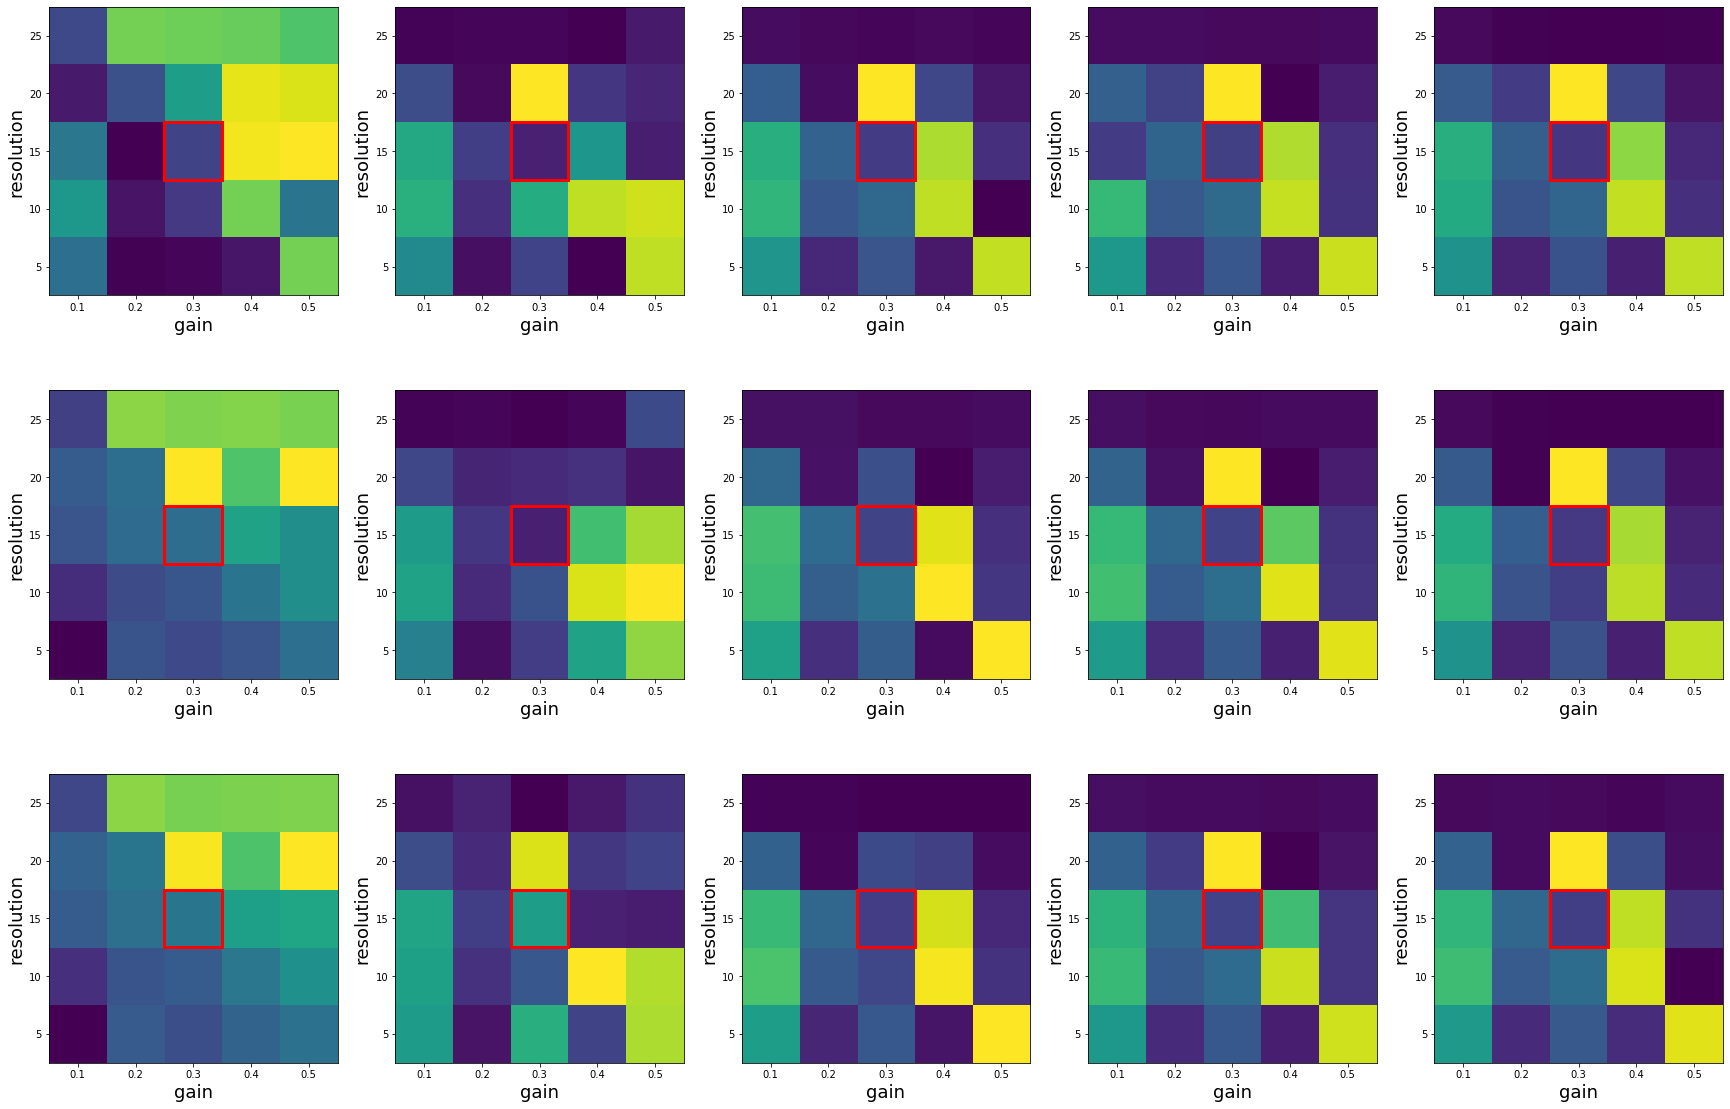

In [24]:
axes = plt.subplots(3, 5, figsize=(30,20))[1].reshape(-1)
vmin = np.min(all_bootstrap_dist)
vmax = np.max(all_bootstrap_dist)
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for b,ax in zip(all_bootstrap_dist,axes):
    ax.imshow(b)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(gains)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(resolutions)
    ax.set_ylim(-.5,4.5)
    ax.set_xlabel('gain', fontsize=18)
    ax.set_ylabel('resolution', fontsize=18)
    highlight_cell(2,2, ax=ax,color="red", linewidth=3)

Text(0.5, 1.0, '95% CI of bottleneck distances')

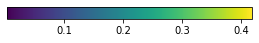

In [20]:
# axis of the colormap
a = np.array([[vmin,vmax]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('95% CI of bottleneck distances')

## Generate the resulted Mapper Graphs

In [21]:
resolution = 15
gain = 0.3
all_mappers = []
all_exps = []
function = predictions
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([resolution]), "gains": np.array([gain]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=5)}

for method in methods:
    i = 0
    for exp in explanations[method]:
        M = MapperComplex(**params).fit(exp)
        all_mappers.append(M)
        all_exps.append(exp)

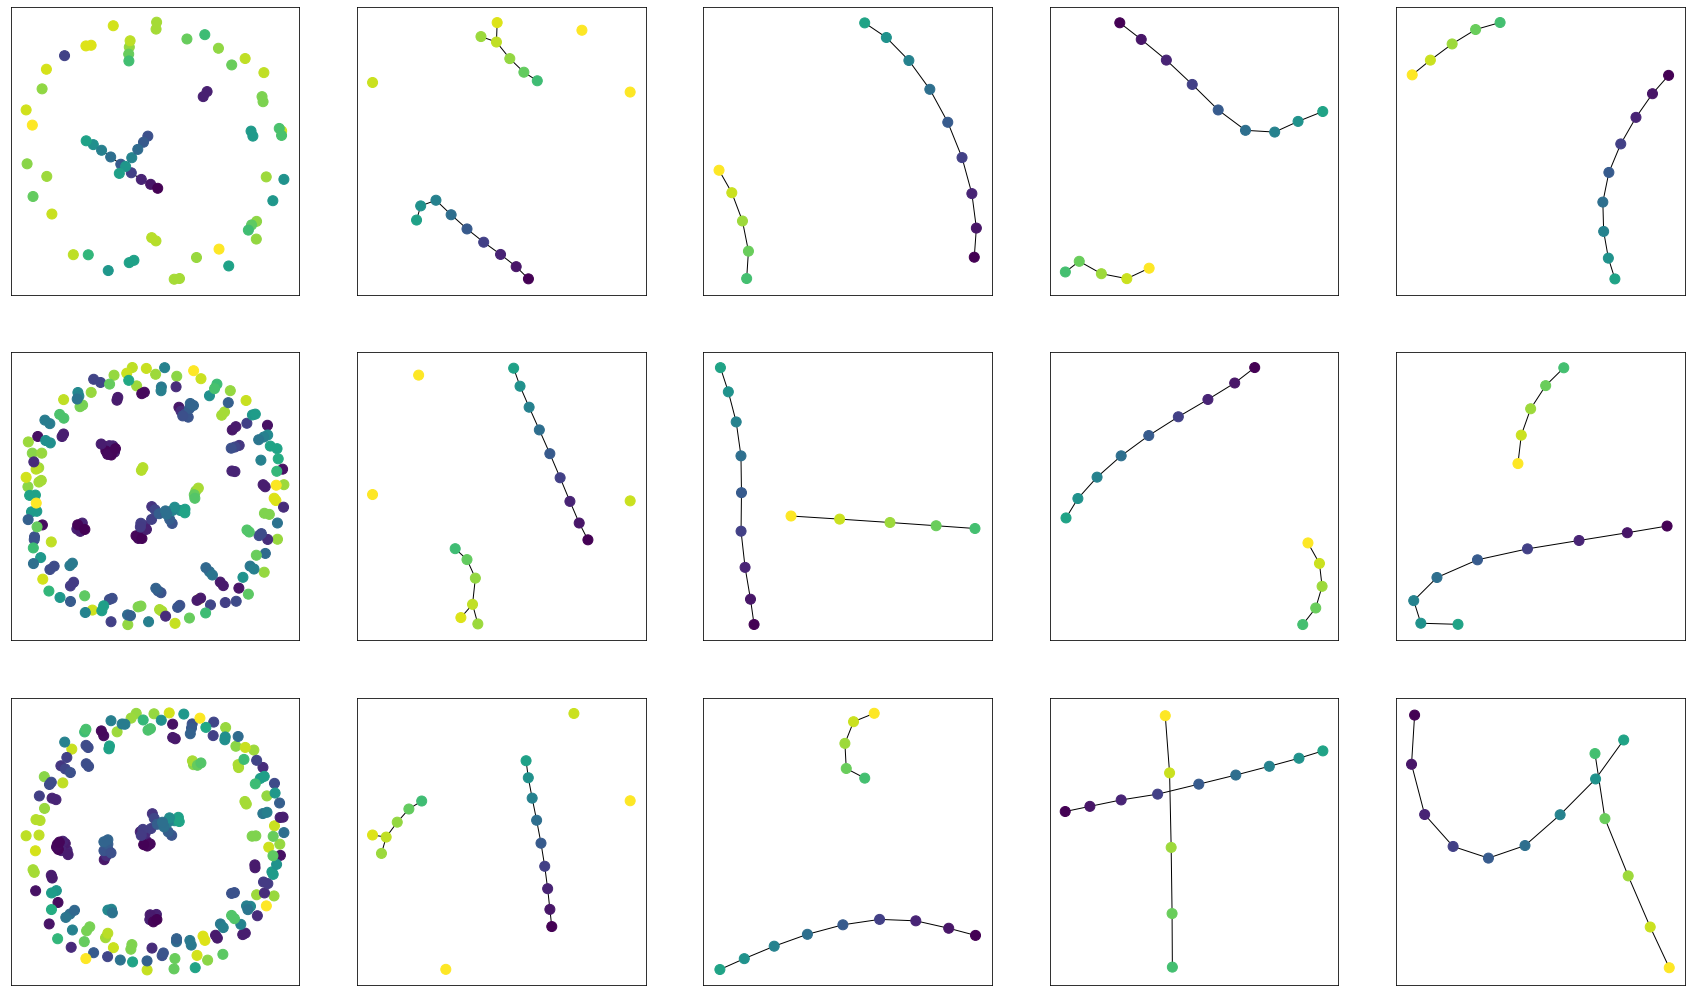

In [22]:
axes = plt.subplots(3, 5, figsize=(30,18))[1].reshape(-1)
all_mappers_flatten = []
vals = []
for (M, ax) in zip(all_mappers, axes):
    G = mapper2networkx(M)
    nx.draw(G, pos=nx.spring_layout(G), 
            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()], ax=ax,node_size=100)
    vals += [M.node_info_[node]["colors"][0] for node in G.nodes()]
    ax.axis('on')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()

Text(0.5, 1.0, '95% CI of bottleneck distances')

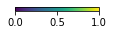

In [25]:
# axis of the colormap
a = np.array([[0,1]])
plt.figure(figsize=(1.5,9))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('95% CI of bottleneck distances')

## Compute the pairwise distances among the topological graphs with different methods and baselines.

In [83]:
all_dists = np.zeros((len(all_mappers),len(all_mappers)))
for i in range(len(all_mappers)):
    for j in range(i+1,len(all_mappers)):
        all_dists[i,j] = bottleneck_distance(all_mappers[i],all_mappers[j])
        all_dists[j,i] = all_dists[i,j]

Text(0.5, 1.0, 'bottleneck distance')

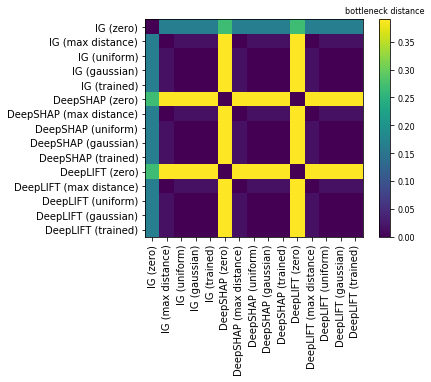

In [85]:
im=plt.imshow(all_dists)
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
plt.xticks(np.arange(15),names,rotation=90)
plt.yticks(np.arange(15),names,rotation=0)
plt.ylim(14.5,-.5)
clb=plt.colorbar(im)
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('bottleneck distance',fontsize=8)

## Plotting the row wise sum of pairwise distance matrices to reveal the comparisons

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

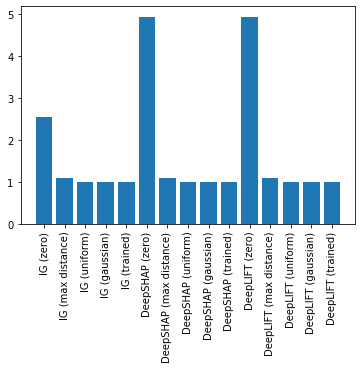

In [84]:
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
plt.bar(names,np.sum(all_dists,0))
plt.xticks(rotation='vertical')
# plt.title('Topological Consensus Among Different Explanation Methods')